In [1]:
import torch 
import torchvision 
import numpy as np

import os
import pandas as pd
import albumentations as A
import albumentations.pytorch
import cv2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# import torch.nn.functional as F

import sys
sys.path.append('../')
from dataset import val_transforms, CDataset

In [2]:
import easydict 
args = easydict.EasyDict({ "batch_size": 256, 
                          "epochs": 30, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':1,
                          'workers':16,
                         'print_freq':2000,
                         'saved_dir':'../trained_models/stain_training_stomach/checkpoint.pt'})

In [3]:
# make saved dir
from pathlib import Path
path = Path(args.saved_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)

In [4]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

3
cuda:1


In [5]:
from augment import *

# stain_mat = np.array([[ 0.63854984,  0.25636421, -0.05117216],
#  [ 0.72885336,  0.89928835,  0.35397438],
#  [ 0.24388358,  0.33553481, -0.92226462]])

stain_mat = array([[ 0.59851184, -0.18189402, -0.02771543],
       [ 0.47783455,  0.01465236,  0.17879342],
       [ 0.63844483,  0.09446875, -0.08804648]])

def HEColor_augment(img, sigma1=0.1, sigma2=1):
    img = 255. - img.astype(float)
#     _, StainsFloat, stain_mat  = color_deconvolution_routine(img)
    inv_mat = LA.inv(stain_mat)

#     conversion to Stain & eosin domain
#     od_img = convert_RGB_to_OD(img)
    sda_img = rgb_to_sda(img)
    conv_img = np.matmul(sda_img, inv_mat.T)
    
    '''
        .. [#] Tellez, David, Geert Litjens, Peter Bandi, Wouter Bulten,
               John-Melle Bokhorst, Francesco Ciompi, and Jeroen van der Laak.
               "Quantifying the effects of data augmentation and stain color
               normalization in convolutional neural networks for computational
               pathology." arXiv preprint arXiv:1902.06543 (2019).
    '''
#     only scale for main axis
    for i in range(conv_img.shape[-1]) :
        if i == 0 :
            alpha = np.random.uniform(1 - sigma1, 1 + sigma1)
            conv_img[:,:,i] *= alpha
#         beta = np.random.uniform(-sigma2, sigma2)
        beta = np.random.normal(0, sigma2)            
        conv_img[:,:,i] += beta
        
    aug_img = np.matmul(conv_img, stain_mat.T)
#     aug_img = convert_OD_to_RGB(aug_img)
    aug_img = sda_to_rgb(aug_img)
    
    return np.clip(aug_img, 0, 255)

class HEColorAugment(ImageOnlyTransform) :    
    def __init__(
        self,
        sigma1=0.1,
        sigma2=3.,
        always_apply=False,
        p=1.,
 ):
        super(HEColorAugment, self).__init__(always_apply, p)
        self.sigma1= sigma1
        self.sigma2= sigma2
        
    def apply(self, img,  **params):
        return HEColor_augment(img, self.sigma1, self.sigma2)

In [6]:
IMAGE_SIZE = 256
from augment import HEColorAugment
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
    A.OneOf([
        A.HorizontalFlip(p=.8),
        A.VerticalFlip(p=.8),
        A.RandomRotate90(p=.8)]
    ),
#     A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=[0.95,1.05],ratio=[0.95,1.05],p=0.5),
#     A.transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.05, p=.8),
    HEColorAugment(sigma1=0.2, sigma2=1., p=0.8),
], p=1.0) 

In [7]:
import albumentations as A
import albumentations.pytorch
import cv2
from augment import HEColorAugment, rgb_to_sda

class CDataset(Dataset):
    def __init__(self, df, defaultpath='/home/beomgon/Dataset/new_patches/', transform=None):
        self.df = df
        self.transform = transform
        self.dir = defaultpath

    def __len__(self):
        return len(self.df)   

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 4]
#         print(pid)

        image = cv2.imread(self.dir + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = (image.astype(np.float32)-128.)/128.
        
#         if image is uint8, normalization by 255 is done automatically by albumebtation(ToTensor method)
        if self.transform:
            timage = self.transform(image=image)
            image = timage['image']
            
#         image = rgb_to_sda(image)
        
        image =  torch.tensor(image, dtype=torch.float32)/255.
        #image = (torch.tensor(image, dtype=torch.float32)-128)/128
        image = image.permute(2,0,1)
            
        label = self.df.iloc[idx, 5]
        return image, label, path

In [8]:
train_df = pd.read_csv('../dataframe/train_New_Stomach_df.csv')
train_dataset = CDataset(train_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/', 
                         transform=train_transforms)

val_df = pd.read_csv('../dataframe/val_New_Stomach_df.csv')
val_dataset = CDataset(val_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                       transform=val_transforms)  

test_df = pd.read_csv('../dataframe/test_New_Stomach_df.csv')
test_dataset = CDataset(test_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                        transform=val_transforms)  

In [9]:
image, label, path = next(iter(train_dataset))
# image

In [10]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)


In [11]:
images, labels, paths = next(iter(train_loader))
images.shape

torch.Size([256, 3, 256, 256])

In [12]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
# optimizer = torch.optim.SGD(
#        params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
# optimizer = torch.optim.SGD(params, lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], 
                                                    gamma=0.2)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
criterion = nn.CrossEntropyLoss().to(device)

In [13]:
from main import *

In [14]:
ratio = [-1, 0., 0.05, 0.1, 0.2, 0.4]
acc_list = []
test_acc = []

for num in range(len(ratio)) :
    args.saved_dir = '../trained_models/resnet/stain' + str(num) + '/checkpoint.pt'
    path = Path(args.saved_dir.split('checkpoint')[0])
    path.mkdir(parents=True, exist_ok=True)  
    args.ratio = ratio[num]
    
    if num == 0 :
        train_transforms = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
            A.OneOf([
                A.HorizontalFlip(p=.8),
                A.VerticalFlip(p=.8),
                A.RandomRotate90(p=.8)]
            ),
        #     A.transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.05, p=.8),
            # HEColorAugment(sigma1=args.ratio, sigma2=1., p=0.8),
        ], p=1.0)   
    else :
        train_transforms = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
            A.OneOf([
                A.HorizontalFlip(p=.8),
                A.VerticalFlip(p=.8),
                A.RandomRotate90(p=.8)]
            ),
        #     A.transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.05, p=.8),
            HEColorAugment(sigma1=args.ratio, sigma2=1., p=0.8),
        ], p=1.0)           
    
    train_df = pd.read_csv('../dataframe/train_New_Stomach_df.csv')
    train_dataset = CDataset(train_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/', 
                         transform=train_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)
    
    model = models.resnet18(pretrained=True)
    # model.fc.out_features = 3
    model.fc = nn.Linear(512, 3)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
    # optimizer = torch.optim.SGD(
    #        params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], 
                                                        gamma=0.2)
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_acc1 = 0
    acc1 = 0
    train_loss = []
    val_acc = []

    for epoch in range(args.epochs):
        losses = train(train_loader, model, criterion, optimizer, epoch, args)
        scheduler.step()

        # evaluate after every epoch
        acc1 = validate(val_loader, model, criterion, args)   
        val_acc.append(acc1.item())

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1) 

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.saved_dir)   
        
    checkpoint = torch.load(args.saved_dir)
    model.load_state_dict(checkpoint['state_dict'])
    acc1 = validate(test_loader, model, criterion, args)    
    print('************* test number {} ratio {} acc{} *************'.format(num, ratio[num], acc1))    
    acc_list.append(val_acc)    
    test_acc.append(acc1)
    

Epoch: [0][  0/297]	Time  2.337 ( 2.337)	Data  1.655 ( 1.655)	Loss 1.2302e+00 (1.2302e+00)	Acc@1  35.16 ( 35.16)
Test: [  0/102]	Time  1.785 ( 1.785)	Loss 3.5500e+00 (3.5500e+00)	Acc@1  32.42 ( 32.42)
 * Acc@1 33.215
Epoch: [1][  0/297]	Time  2.134 ( 2.134)	Data  1.866 ( 1.866)	Loss 9.3142e-01 (9.3142e-01)	Acc@1  65.62 ( 65.62)
Test: [  0/102]	Time  1.857 ( 1.857)	Loss 1.4157e+00 (1.4157e+00)	Acc@1  47.27 ( 47.27)
 * Acc@1 51.246
Epoch: [2][  0/297]	Time  2.137 ( 2.137)	Data  1.922 ( 1.922)	Loss 4.7607e-01 (4.7607e-01)	Acc@1  81.25 ( 81.25)
Test: [  0/102]	Time  2.040 ( 2.040)	Loss 7.9045e-01 (7.9045e-01)	Acc@1  69.92 ( 69.92)
 * Acc@1 75.583
Epoch: [3][  0/297]	Time  1.983 ( 1.983)	Data  1.773 ( 1.773)	Loss 3.5829e-01 (3.5829e-01)	Acc@1  85.55 ( 85.55)
Test: [  0/102]	Time  1.735 ( 1.735)	Loss 2.8253e+00 (2.8253e+00)	Acc@1  52.73 ( 52.73)
 * Acc@1 52.494
Epoch: [4][  0/297]	Time  1.847 ( 1.847)	Data  1.635 ( 1.635)	Loss 5.0139e-01 (5.0139e-01)	Acc@1  80.47 ( 80.47)
Test: [  0/102]	Tim

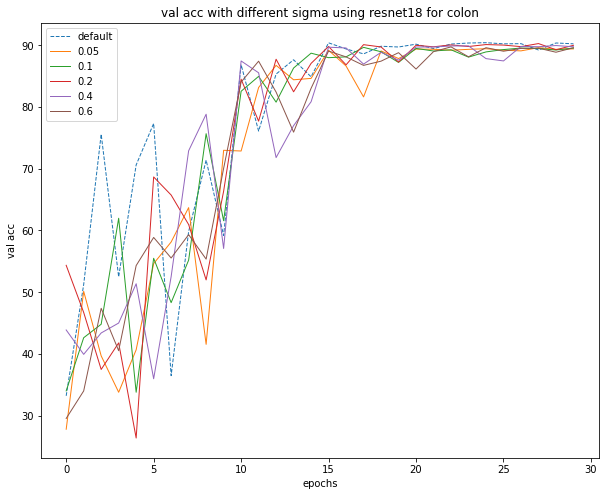

[tensor(91.3685, device='cuda:1'), tensor(91.7521, device='cuda:1'), tensor(91.2163, device='cuda:1'), tensor(91.3420, device='cuda:1'), tensor(91.4346, device='cuda:1'), tensor(91.0444, device='cuda:1')]


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(args.epochs)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['lines.linewidth'] = 1
plt.plot(epochs, acc_list[0], linestyle='--')
plt.plot(epochs, acc_list[1])
plt.plot(epochs, acc_list[2])
plt.plot(epochs, acc_list[3])
plt.plot(epochs, acc_list[4])
plt.plot(epochs, acc_list[5])
plt.legend(['default', '0.0', '0.05', '0.1', '0.2', '0.4'])
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.title('val acc with different sigma using resnet18 for colon')
# plt.axis([10, 30, 88, 94])
plt.show()
print(test_acc)